# C.-C. Chen and W.-J. Wu : A secure Boolean-based multi-secret image sharing scheme

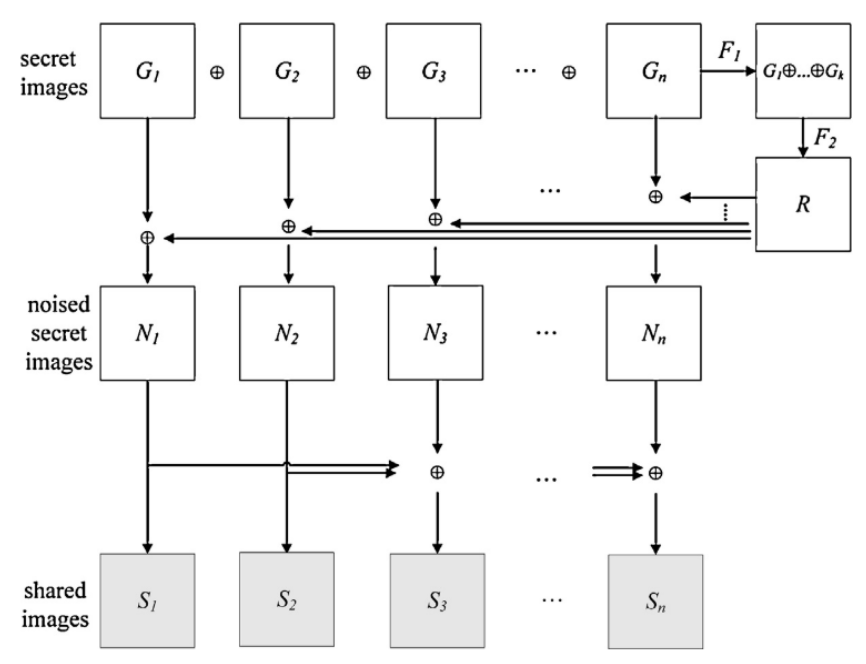

<br/>
Proposed (n, n) secret sharing scheme procedure.

## Initial (n, n) secret sharing scheme for sharing n-1 secrets

In [1]:
# imports
from PIL import Image
import numpy as np
import random
import sys
import os
import shutil
import matplotlib.pyplot as plt

In [140]:
# Importing images from /secrets
def import_images():
    # Importing images
    images = []
    for filename in os.listdir('secrets'):
        img = Image.open('secrets/' + filename)
        img = img.convert('RGB')
        img = img.resize((256, 256))
        img = np.array(img)
        images.append(img)
    return images


def import_images_grayscale():
    # Importing images
    images = []
    for filename in os.listdir('secrets'):
        img = Image.open('secrets/' + filename)
        img = img.convert('L')  # Convert to grayscale
        img = img.resize((256, 256))  # Resize to (256, 256)
        img = np.array(img)  # Convert to numpy array
        
        # Unpack each 8-bit pixel into its corresponding 8 bit planes
        bit_planes = np.unpackbits(img[:, :, np.newaxis], axis=2)
        images.append(bit_planes)
    
    return images

In [144]:
# Plotting images
def plot_images(images):
    num_images = len(images)
    rows = max(2, num_images // 2)
    cols = min(4, (num_images + 1) // 2)
    
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axs = axs.flatten()
    
    for i in range(len(images)):
        axs[i].imshow(images[i])
        axs[i].axis('off')  # Hide axes
    
    # Hide any remaining subplots
    for i in range(len(images), len(axs)):
        axs[i].axis('off')
    
    plt.show()
    
def combine_bit_planes(bit_planes):
    combined_image = np.packbits(bit_planes, axis=2)
    return combined_image[:, :, 0]

def plot_bit_planes(bit_planes):
    num_planes = bit_planes.shape[2]
    rows = max(2, num_planes // 2)
    cols = min(4, (num_planes + 1) // 2)
    
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axs = axs.flatten()
    
    for i in range(num_planes):
        axs[i].imshow(bit_planes[:, :, i], cmap='gray')
        axs[i].axis('off')  # Hide axes
    
    # Hide any remaining subplots
    for i in range(num_planes, len(axs)):
        axs[i].axis('off')
    
    plt.show()

In [83]:
# Generating a Random Matrix
def generate_random_matrix(width, height, channels):
    np.random.randint(0, 256, (width, height, channels))

In [90]:
# Generating the Shares for the Secret Images
def generate_shares(images):
    width, height, channels = images[0].shape
    R = np.random.randint(0, 256, (width, height, channels))
    B = []  # Bi = R ^ Gi
    for i in range(len(images)):
        B.append(np.bitwise_xor(images[i], R))
    # Generating the shares
    shares = []
    shares.append(B[0])
    for i in range(1, len(images)):
        shares.append(np.bitwise_xor(B[i], B[i-1]))
    shares.append(np.bitwise_xor(images[0], B[-1]))
    return shares, R

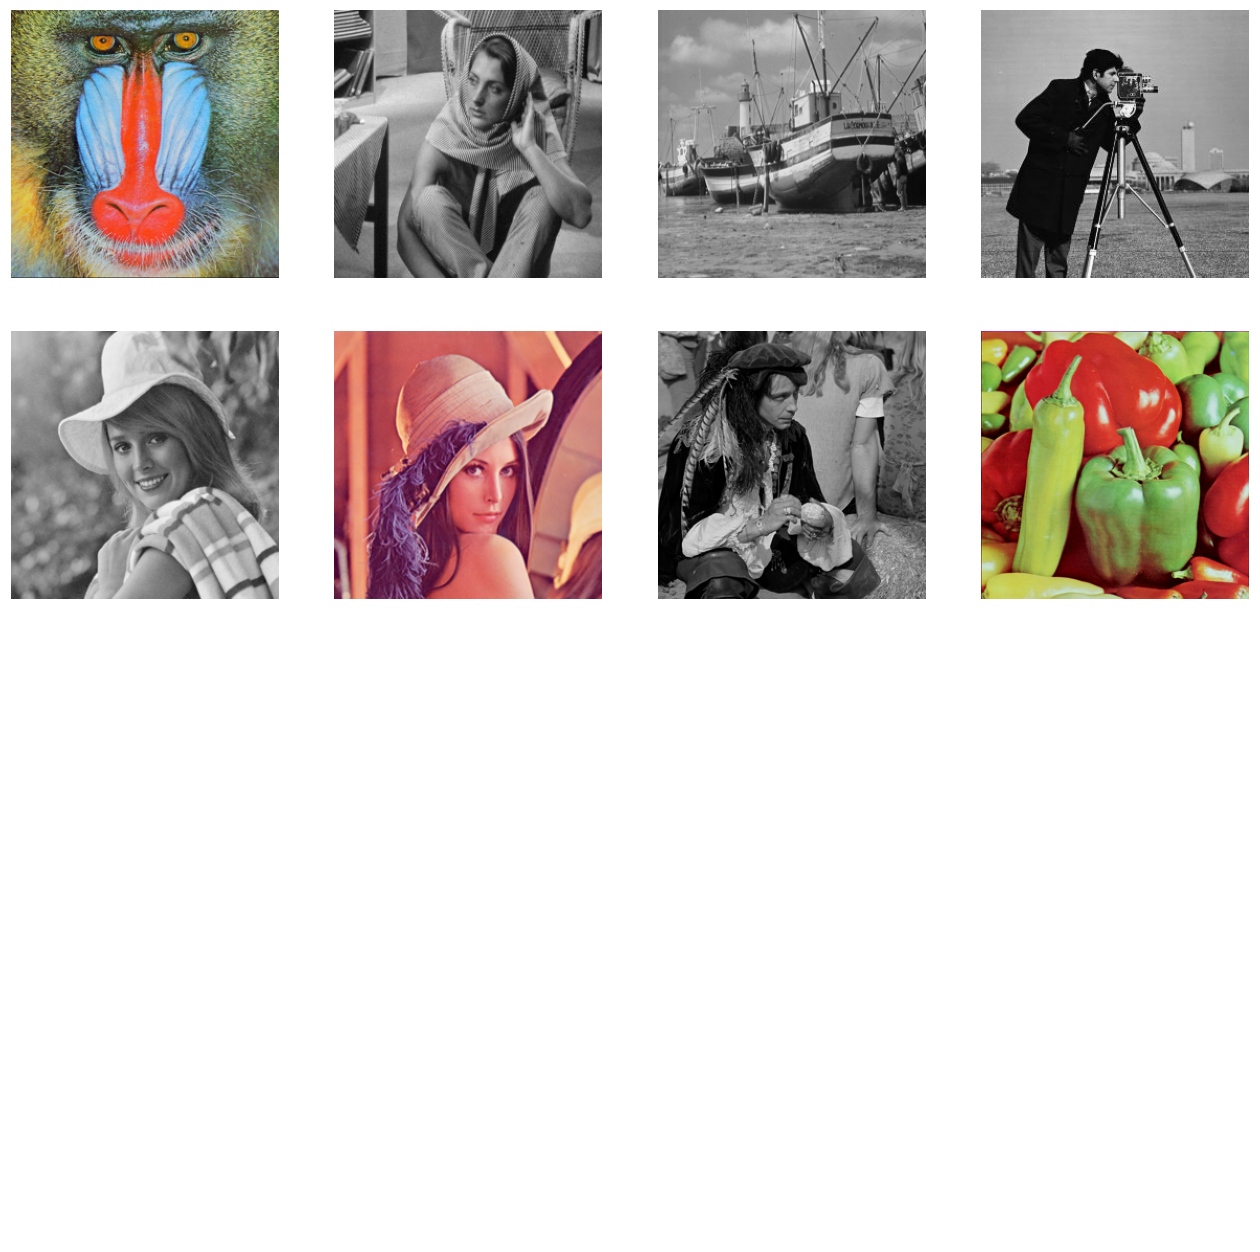

In [91]:
# Calling the main function
images = import_images()
plot_images(images)

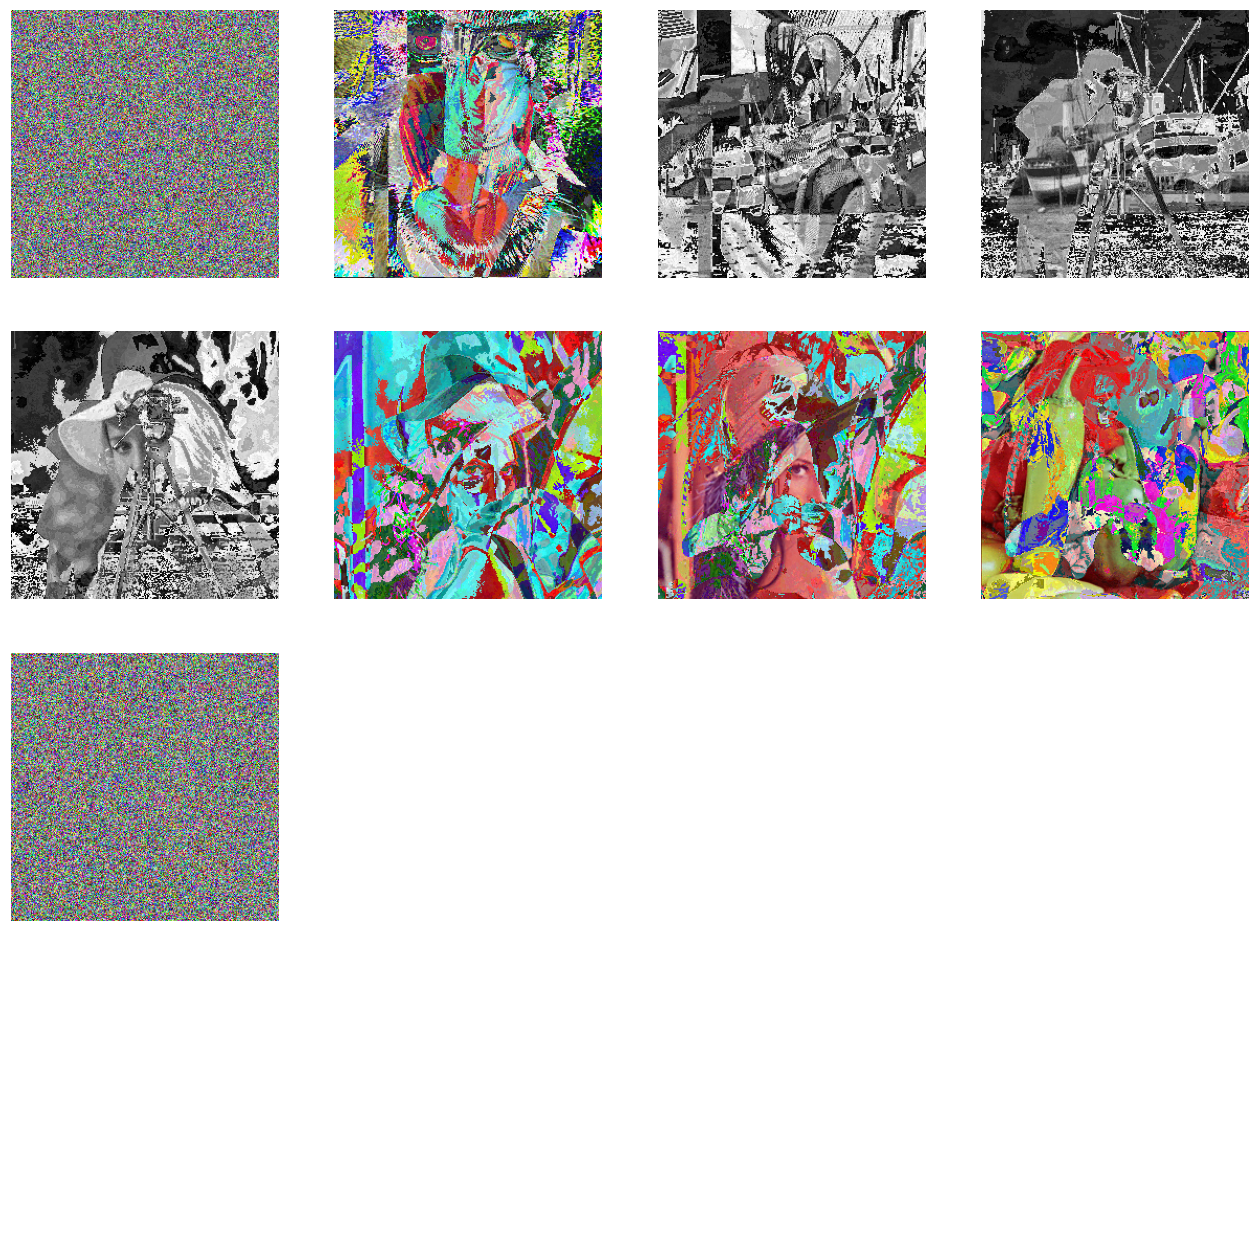

In [92]:
shares, R = generate_shares(images)
plot_images(shares)

### Recovering the secret image

In [93]:
# Recovery
def XOR_all(shares):
    G1 = shares[0]
    for i in range(1, len(shares)):
        G1 = np.bitwise_xor(G1, shares[i])
    return G1

def RandomImageRrecovery(shares):
    G1 = XOR_all(shares)
    R = np.bitwise_xor(shares[0], G1)
    return G1, R
  
def Recovery(shares):
    G1, RandomRecovered = RandomImageRrecovery(shares)
    
    # check if the random image is the same as the original random image
    if np.array_equal(RandomRecovered, R):
        print("Random Image Recovery Successful")
    else:
        print("Random Image Recovery Failed")
        return None
    
    RecoveredImages = []
    RecoveredImages.append(G1)
    for i in range(1, len(shares)-1):
        RecoveredImages.append(np.bitwise_xor(shares[i], RecoveredImages[i-1]))
    return RecoveredImages

Random Image Recovery Successful


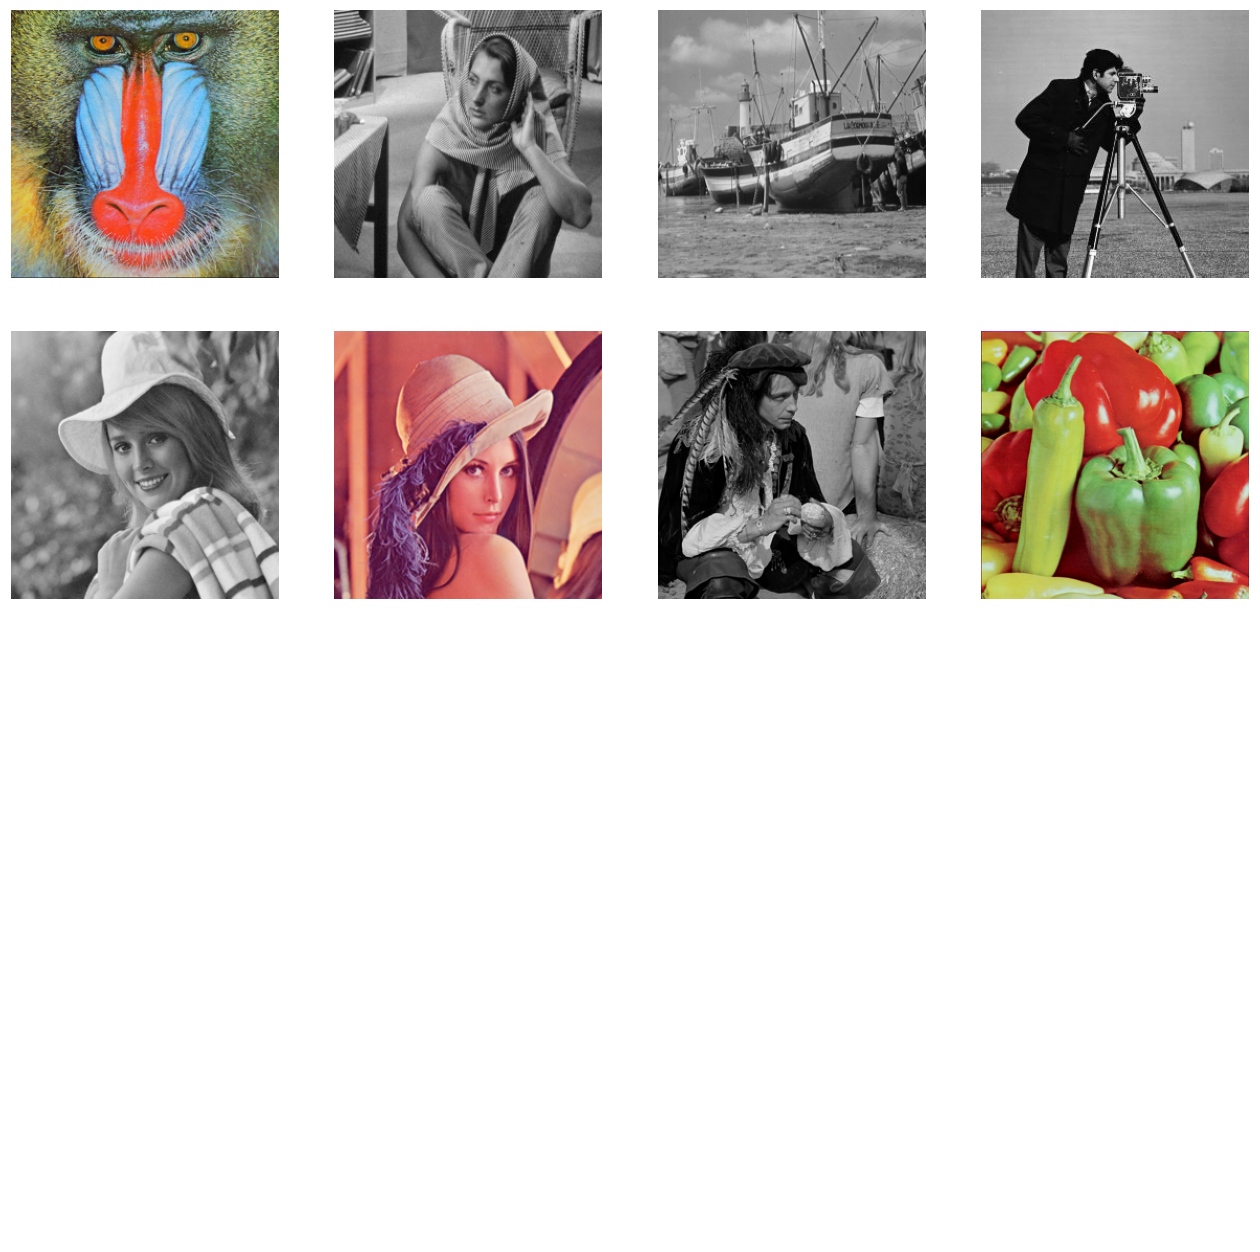

In [94]:
RecoveredImages = Recovery(shares)


# Plotting the recovered images
plot_images(RecoveredImages)

### Accuracy of the scheme

In [95]:
# Accuracy
def accuracy(images, RecoveredImages):
    acc = 0
    for i in range(len(images)):
        if np.array_equal(images[i], RecoveredImages[i]):
            acc += 1
    return acc / len(images)
  
print("Accuracy: ", accuracy(images, RecoveredImages))

Accuracy:  1.0


## Proposed (n, n) secret sharing scheme for sharing n secrets

In [159]:
import numpy as np

def F1(images):
    Random_intermediate = images[0]
    for i in range(1, len(images)):
        Random_intermediate = np.bitwise_xor(Random_intermediate, images[i])
    return Random_intermediate

# bitwise shift: circular shift for (x, y) by (x+y)%256
def F2(Random_intermediate):
    # bitwise shift every pixel by (x+y)%256
    for i in range(len(Random_intermediate)):
        for j in range(len(Random_intermediate[i])):
            shift_amount = (i + j) % 8
            # Perform a circular bitwise shift
            Random_intermediate[i][j] = Random_intermediate[i][j] >> shift_amount | Random_intermediate[i][j] << (8 - shift_amount)
    return Random_intermediate

def GenerateRandomImage(images):
    k = 2 * len(images)//2
    Random_intermediate = F1(images[:k])
    RandomImage = F2(Random_intermediate)
    return RandomImage


In [160]:
def getNoisedImages(images):
    RandomImage = GenerateRandomImage(images)
    # plot_images([RandomImage])
    NoisedImages = []
    for i in range(len(images)):
        NoisedImages.append(np.bitwise_xor(images[i], RandomImage))
    return RandomImage, NoisedImages
  

def getShares(images):
    RandomImage, NoisedImages = getNoisedImages(images)
    shares = []
    shares.append(NoisedImages[0])
    shares.append(NoisedImages[1])
    for i in range(2, len(NoisedImages)):
        shares.append(np.bitwise_xor(np.bitwise_xor(NoisedImages[i], NoisedImages[i-1]), NoisedImages[i-2]))
        
    return shares, RandomImage

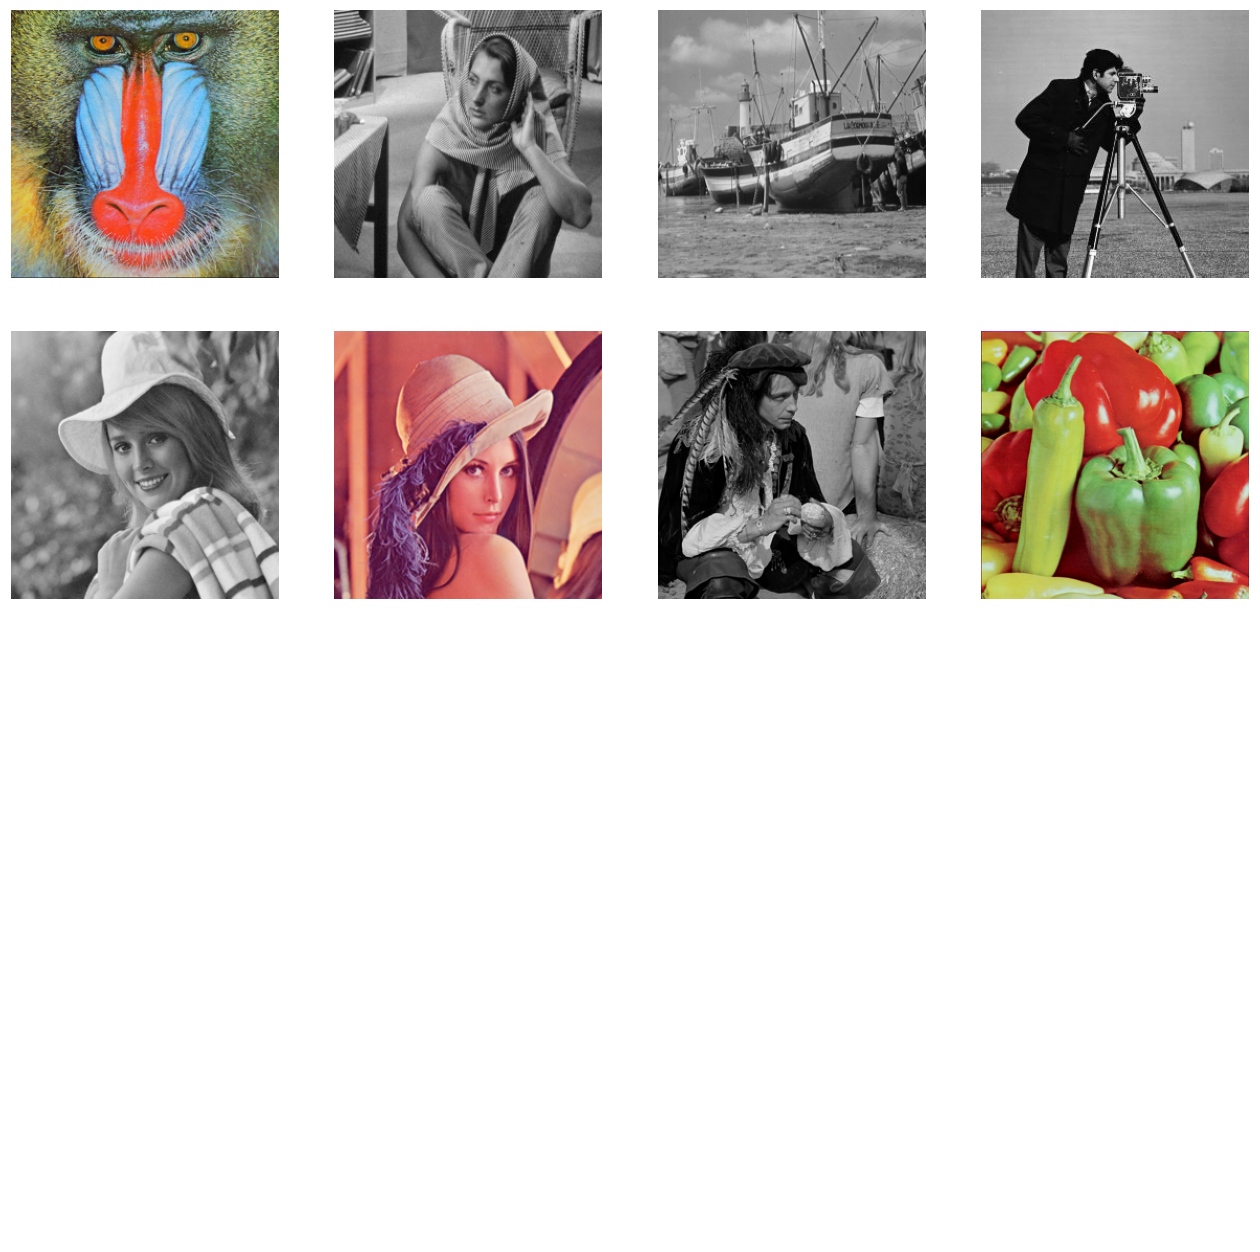

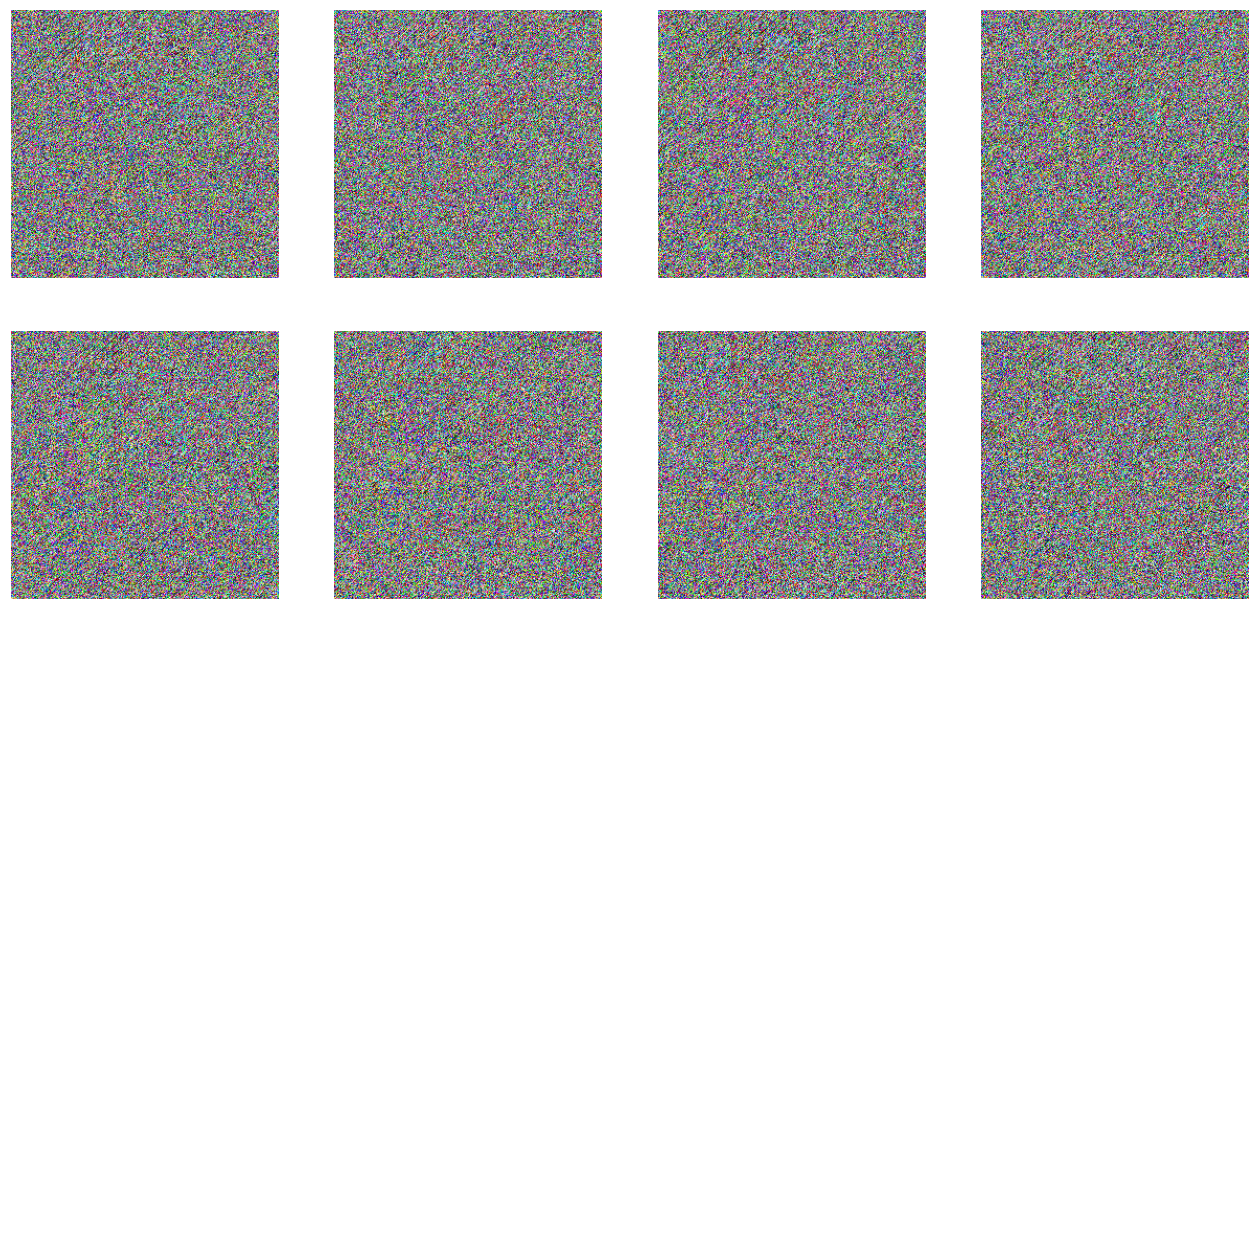

In [161]:
# plot images
images = import_images()

plot_images(images)

shares, RandomImage = getShares(images)

plot_images(shares)

### Recovering the secret images

In [170]:
def generateNoisedImages(shares):
    NoisedImages = []
    NoisedImages.append(shares[0])
    NoisedImages.append(shares[1])
    for i in range(2, len(shares)):
        NoisedImages.append(np.bitwise_xor(np.bitwise_xor(NoisedImages[i-1], NoisedImages[i-2]), shares[i]))
    return NoisedImages
  
def getRecoveredImages(shares):
    NoisedImages = generateNoisedImages(shares)
    RandomImageRecovered = GenerateRandomImage(NoisedImages)
    # check if the random image is the same as the original random image
    if np.array_equal(RandomImageRecovered, RandomImage):
        print("Random Image Recovery Successful")
    else:
        print("Random Image Recovery Failed")
    RecoveredImages = []
    for i in range(len(NoisedImages)):
        RecoveredImages.append(np.bitwise_xor(NoisedImages[i], RandomImageRecovered))
    return RecoveredImages

Random Image Recovery Successful


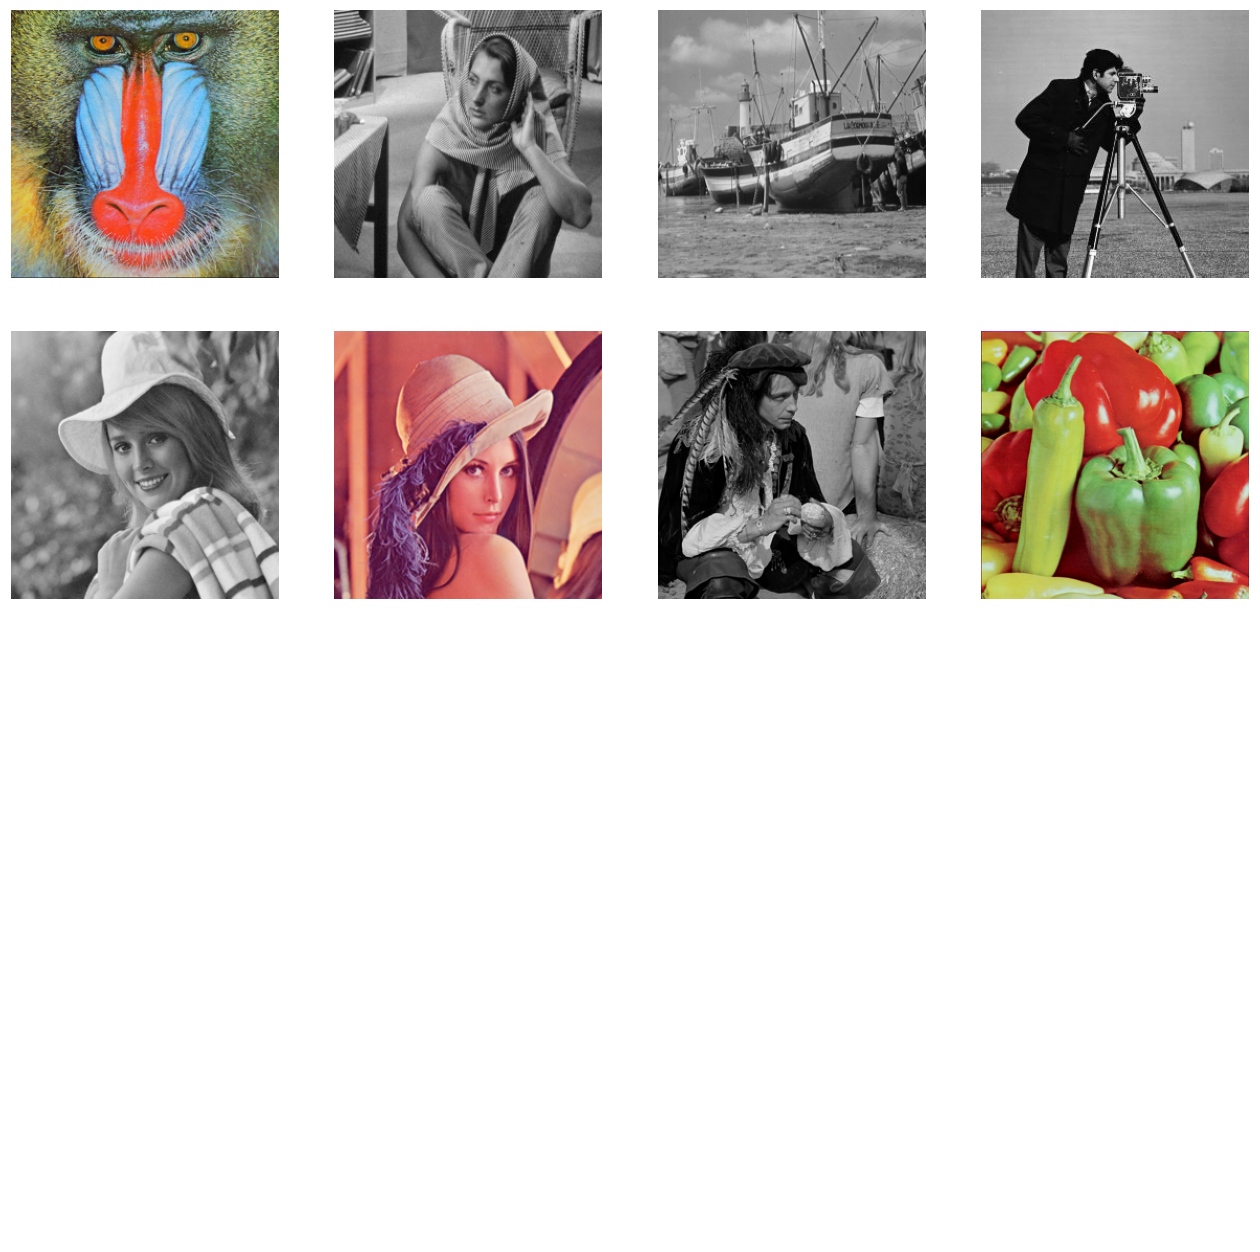

In [171]:
recoveredImages = getRecoveredImages(shares)

plot_images(recoveredImages)